In [1]:
from matplotlib import rc, font_manager as fm

# 나눔고딕 폰트 경로 설정
font_location = 'data/나눔고딕/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()

# 폰트 설정
rc('font', family=font_name)

In [2]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.
'sudo'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [3]:
import lightgbm
lightgbm.__version__

'3.3.2'

In [4]:
import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## 데이터프레임 만들기 파이널용

In [5]:
#k폴드, 라이트gbm 베이스라인 코드

data1 = pd.read_csv('data/골목상권_데이터230914.csv')

### 평일/주말 칼럼 만들기

In [6]:
# 월요일부터 금요일까지의 생활인구 수 컬럼 이름
columns_to_sum1 = ['월요일_생활인구_수', '화요일_생활인구_수', '수요일_생활인구_수', '목요일_생활인구_수', '금요일_생활인구_수']
columns_to_sum2 = ['토요일_생활인구_수', '일요일_생활인구_수']

# data3 데이터프레임에서 해당 컬럼을 더하고 각 5, 2로 나누어서 평일, 주말 생활인구수 컬럼 생성
data1['평일_생활인구_평균'] = data1[columns_to_sum1].sum(axis=1) / 5
data1['주말_생활인구_평균'] = data1[columns_to_sum2].sum(axis=1) / 2

data1 = data1.drop(['월요일_생활인구_수','화요일_생활인구_수', '수요일_생활인구_수', '목요일_생활인구_수', '금요일_생활인구_수', '토요일_생활인구_수', '일요일_생활인구_수'], axis=1)
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 53 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   매출                      2472 non-null   float64
 1   기준_년_코드                 2472 non-null   int64  
 2   상권_구분_코드_명              2472 non-null   object 
 3   상권_코드                   2472 non-null   int64  
 4   상권_코드_명                 2472 non-null   object 
 5   점포수                     2472 non-null   int64  
 6   시간대1                    2472 non-null   int64  
 7   시간대2                    2472 non-null   int64  
 8   시간대3                    2472 non-null   int64  
 9   시간대4                    2472 non-null   int64  
 10  시간대5                    2472 non-null   int64  
 11  분기_1                    2472 non-null   int64  
 12  분기_2                    2472 non-null   int64  
 13  분기_3                    2472 non-null   int64  
 14  총 상주인구 수                2472 non-null   

### 아파트 세대 수 합치고 총 세대수합으로 만들기

In [7]:
# 주어진 칼럼들의 합 구하기
data1['상권내_총_아파트_세대_수'] = data1[['아파트_가격_1_억_미만_세대_수', '아파트_가격_1_억_세대_수', '아파트_가격_2_억_세대_수', 
               '아파트_가격_3_억_세대_수', '아파트_가격_4_억_세대_수', '아파트_가격_5_억_세대_수', 
               '아파트_가격_6_억_이상_세대_수']].sum(axis=1)

# 주어진 칼럼들 삭제
data1 = data1.drop(columns=['아파트_가격_1_억_미만_세대_수', '아파트_가격_1_억_세대_수', 
                              '아파트_가격_2_억_세대_수', '아파트_가격_3_억_세대_수', 
                              '아파트_가격_4_억_세대_수', '아파트_가격_5_억_세대_수', 
                              '아파트_가격_6_억_이상_세대_수'])
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 47 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   매출                      2472 non-null   float64
 1   기준_년_코드                 2472 non-null   int64  
 2   상권_구분_코드_명              2472 non-null   object 
 3   상권_코드                   2472 non-null   int64  
 4   상권_코드_명                 2472 non-null   object 
 5   점포수                     2472 non-null   int64  
 6   시간대1                    2472 non-null   int64  
 7   시간대2                    2472 non-null   int64  
 8   시간대3                    2472 non-null   int64  
 9   시간대4                    2472 non-null   int64  
 10  시간대5                    2472 non-null   int64  
 11  분기_1                    2472 non-null   int64  
 12  분기_2                    2472 non-null   int64  
 13  분기_3                    2472 non-null   int64  
 14  총 상주인구 수                2472 non-null   

### 아파트 세대 수 합치고 총 세대수합으로 만들기

In [8]:
# 주어진 칼럼들의 합 구하기
data1['배후지_총_아파트_세대_수'] = data1[['배후지_아파트_가격_1_억_미만_세대_수', '배후지_아파트_가격_1_억_세대_수', '배후지_아파트_가격_2_억_세대_수',
       '배후지_아파트_가격_3_억_세대_수', '배후지_아파트_가격_4_억_세대_수', '배후지_아파트_가격_5_억_세대_수',
       '배후지_아파트_가격_6_억_이상_세대_수']].sum(axis=1)

# 주어진 칼럼들 삭제
data1 = data1.drop(columns=['배후지_아파트_가격_1_억_미만_세대_수', '배후지_아파트_가격_1_억_세대_수', '배후지_아파트_가격_2_억_세대_수',
       '배후지_아파트_가격_3_억_세대_수', '배후지_아파트_가격_4_억_세대_수', '배후지_아파트_가격_5_억_세대_수',
       '배후지_아파트_가격_6_억_이상_세대_수'])
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   매출                2472 non-null   float64
 1   기준_년_코드           2472 non-null   int64  
 2   상권_구분_코드_명        2472 non-null   object 
 3   상권_코드             2472 non-null   int64  
 4   상권_코드_명           2472 non-null   object 
 5   점포수               2472 non-null   int64  
 6   시간대1              2472 non-null   int64  
 7   시간대2              2472 non-null   int64  
 8   시간대3              2472 non-null   int64  
 9   시간대4              2472 non-null   int64  
 10  시간대5              2472 non-null   int64  
 11  분기_1              2472 non-null   int64  
 12  분기_2              2472 non-null   int64  
 13  분기_3              2472 non-null   int64  
 14  총 상주인구 수          2472 non-null   int64  
 15  총 가구 수            2472 non-null   int64  
 16  총_직장인구_수          2472 non-null   int64  


### 면적당 버스정류장 수

In [9]:
# 주어진 칼럼들의 합 구하기
data1['면적당_버스정류장_수'] = data1['버스정류장_수'] / data1['area'] * 10000

# 주어진 칼럼들 삭제
data1 = data1.drop(columns=['버스정류장_수'])
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   매출                2472 non-null   float64
 1   기준_년_코드           2472 non-null   int64  
 2   상권_구분_코드_명        2472 non-null   object 
 3   상권_코드             2472 non-null   int64  
 4   상권_코드_명           2472 non-null   object 
 5   점포수               2472 non-null   int64  
 6   시간대1              2472 non-null   int64  
 7   시간대2              2472 non-null   int64  
 8   시간대3              2472 non-null   int64  
 9   시간대4              2472 non-null   int64  
 10  시간대5              2472 non-null   int64  
 11  분기_1              2472 non-null   int64  
 12  분기_2              2472 non-null   int64  
 13  분기_3              2472 non-null   int64  
 14  총 상주인구 수          2472 non-null   int64  
 15  총 가구 수            2472 non-null   int64  
 16  총_직장인구_수          2472 non-null   int64  


### 면적당 점포 수

In [10]:
# 주어진 칼럼들의 합 구하기
data1['면적당_점포_수'] = data1['점포수'] / data1['area'] * 10000

# 주어진 칼럼들 삭제
data1 = data1.drop(columns=['점포수'])
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   매출                2472 non-null   float64
 1   기준_년_코드           2472 non-null   int64  
 2   상권_구분_코드_명        2472 non-null   object 
 3   상권_코드             2472 non-null   int64  
 4   상권_코드_명           2472 non-null   object 
 5   시간대1              2472 non-null   int64  
 6   시간대2              2472 non-null   int64  
 7   시간대3              2472 non-null   int64  
 8   시간대4              2472 non-null   int64  
 9   시간대5              2472 non-null   int64  
 10  분기_1              2472 non-null   int64  
 11  분기_2              2472 non-null   int64  
 12  분기_3              2472 non-null   int64  
 13  총 상주인구 수          2472 non-null   int64  
 14  총 가구 수            2472 non-null   int64  
 15  총_직장인구_수          2472 non-null   int64  
 16  아파트_단지_수          2472 non-null   int64  


### 면적당 집객시설 수

In [11]:
# 주어진 칼럼들의 합 구하기
data1['면적당_집객시설_수'] = data1['집객시설_수'] / data1['area'] * 10000

# 주어진 칼럼들 삭제
data1 = data1.drop(columns=['집객시설_수'])
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 41 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   매출                2472 non-null   float64
 1   기준_년_코드           2472 non-null   int64  
 2   상권_구분_코드_명        2472 non-null   object 
 3   상권_코드             2472 non-null   int64  
 4   상권_코드_명           2472 non-null   object 
 5   시간대1              2472 non-null   int64  
 6   시간대2              2472 non-null   int64  
 7   시간대3              2472 non-null   int64  
 8   시간대4              2472 non-null   int64  
 9   시간대5              2472 non-null   int64  
 10  분기_1              2472 non-null   int64  
 11  분기_2              2472 non-null   int64  
 12  분기_3              2472 non-null   int64  
 13  총 상주인구 수          2472 non-null   int64  
 14  총 가구 수            2472 non-null   int64  
 15  총_직장인구_수          2472 non-null   int64  
 16  아파트_단지_수          2472 non-null   int64  


### 직장/상주인구 만들기

In [12]:
data1['직장인구/상주인구'] = data1['총_직장인구_수'] / data1['총 상주인구 수']
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 42 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   매출                2472 non-null   float64
 1   기준_년_코드           2472 non-null   int64  
 2   상권_구분_코드_명        2472 non-null   object 
 3   상권_코드             2472 non-null   int64  
 4   상권_코드_명           2472 non-null   object 
 5   시간대1              2472 non-null   int64  
 6   시간대2              2472 non-null   int64  
 7   시간대3              2472 non-null   int64  
 8   시간대4              2472 non-null   int64  
 9   시간대5              2472 non-null   int64  
 10  분기_1              2472 non-null   int64  
 11  분기_2              2472 non-null   int64  
 12  분기_3              2472 non-null   int64  
 13  총 상주인구 수          2472 non-null   int64  
 14  총 가구 수            2472 non-null   int64  
 15  총_직장인구_수          2472 non-null   int64  
 16  아파트_단지_수          2472 non-null   int64  


### 최종 csv 파일저장

In [13]:
data1 = data1.drop(columns=['총_생활인구_수', '연령대_10_생활인구_수', '연령대_20_생활인구_수', 
                            '연령대_30_생활인구_수', '연령대_40_생활인구_수', '연령대_50_생활인구_수',
                            '연령대_60_이상_생활인구_수', '배후지_아파트_단지_수', '아파트_단지_수'])
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2472 entries, 0 to 2471
Data columns (total 33 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   매출              2472 non-null   float64
 1   기준_년_코드         2472 non-null   int64  
 2   상권_구분_코드_명      2472 non-null   object 
 3   상권_코드           2472 non-null   int64  
 4   상권_코드_명         2472 non-null   object 
 5   시간대1            2472 non-null   int64  
 6   시간대2            2472 non-null   int64  
 7   시간대3            2472 non-null   int64  
 8   시간대4            2472 non-null   int64  
 9   시간대5            2472 non-null   int64  
 10  분기_1            2472 non-null   int64  
 11  분기_2            2472 non-null   int64  
 12  분기_3            2472 non-null   int64  
 13  총 상주인구 수        2472 non-null   int64  
 14  총 가구 수          2472 non-null   int64  
 15  총_직장인구_수        2472 non-null   int64  
 16  시간대_생활인구_수      2472 non-null   int64  
 17  관공서_수           2472 non-null   i

In [15]:
data1.to_csv('Final_골목상권_데이터230917.csv', index=False, encoding = 'utf-8 sig')

### 최종 모델 기본

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 150908	training's l2: 2.27734e+10	valid_1's rmse: 139064	valid_1's l2: 1.93389e+10
[2]	training's rmse: 145486	training's l2: 2.1166e+10	valid_1's rmse: 134295	valid_1's l2: 1.80351e+10
[3]	training's rmse: 140499	training's l2: 1.97399e+10	valid_1's rmse: 129824	valid_1's l2: 1.68543e+10
[4]	training's rmse: 135711	training's l2: 1.84174e+10	valid_1's rmse: 125691	valid_1's l2: 1.57983e+10
[5]	training's rmse: 131180	training's l2: 1.72083e+10	valid_1's rmse: 121964	valid_1's l2: 1.48752e+10
[6]	training's rmse: 126952	training's l2: 1.61168e+10	valid_1's rmse: 118418	valid_1's l2: 1.40227e+10
[7]	training's rmse: 122958	training's l2: 1.51186e+10	valid_1's rmse: 115132	valid_1's l2: 1.32554e+10
[8]	training's rmse: 119259	training's l2: 1.42228e+10	valid_1's rmse: 112096	

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 141744	training's l2: 2.00914e+10	valid_1's rmse: 174691	valid_1's l2: 3.05168e+10
[2]	training's rmse: 136760	training's l2: 1.87033e+10	valid_1's rmse: 169031	valid_1's l2: 2.85715e+10
[3]	training's rmse: 132087	training's l2: 1.74468e+10	valid_1's rmse: 163715	valid_1's l2: 2.68027e+10
[4]	training's rmse: 127666	training's l2: 1.62985e+10	valid_1's rmse: 158734	valid_1's l2: 2.51964e+10
[5]	training's rmse: 123371	training's l2: 1.52204e+10	valid_1's rmse: 153878	valid_1's l2: 2.36783e+10
[6]	training's rmse: 119156	training's l2: 1.41982e+10	valid_1's rmse: 149670	valid_1's l2: 2.24011e+10
[7]	training's rmse: 115223	training's l2: 1.32764e+10	valid_1's rmse: 145739	valid_1's l2: 2.124e+10
[8]	training's rmse: 111620	training's l2: 1.24591e+10	valid_1's rmse: 142369	v

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 145915	training's l2: 2.12911e+10	valid_1's rmse: 160477	valid_1's l2: 2.57528e+10
[2]	training's rmse: 141023	training's l2: 1.98874e+10	valid_1's rmse: 155802	valid_1's l2: 2.42743e+10
[3]	training's rmse: 135919	training's l2: 1.84739e+10	valid_1's rmse: 151064	valid_1's l2: 2.28203e+10
[4]	training's rmse: 131135	training's l2: 1.71963e+10	valid_1's rmse: 146651	valid_1's l2: 2.15065e+10
[5]	training's rmse: 126625	training's l2: 1.60339e+10	valid_1's rmse: 142618	valid_1's l2: 2.03399e+10
[6]	training's rmse: 122506	training's l2: 1.50076e+10	valid_1's rmse: 138673	valid_1's l2: 1.92301e+10
[7]	training's rmse: 118416	training's l2: 1.40223e+10	valid_1's rmse: 135132	valid_1's l2: 1.82606e+10
[8]	training's rmse: 114809	training's l2: 1.31811e+10	valid_1's rmse: 131635

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 152880	training's l2: 2.33724e+10	valid_1's rmse: 130526	valid_1's l2: 1.70369e+10
[2]	training's rmse: 147472	training's l2: 2.17479e+10	valid_1's rmse: 125675	valid_1's l2: 1.57941e+10
[3]	training's rmse: 142440	training's l2: 2.02891e+10	valid_1's rmse: 121221	valid_1's l2: 1.46944e+10
[4]	training's rmse: 137548	training's l2: 1.89196e+10	valid_1's rmse: 116909	valid_1's l2: 1.36678e+10
[5]	training's rmse: 133061	training's l2: 1.77053e+10	valid_1's rmse: 113033	valid_1's l2: 1.27764e+10
[6]	training's rmse: 128681	training's l2: 1.65589e+10	valid_1's rmse: 109233	valid_1's l2: 1.19318e+10
[7]	training's rmse: 124527	training's l2: 1.55069e+10	valid_1's rmse: 105657	valid_1's l2: 1.11633e+10
[8]	training's rmse: 120687	training's l2: 1.45654e+10	valid_1's rmse: 102284

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 151414	training's l2: 2.29262e+10	valid_1's rmse: 137022	valid_1's l2: 1.87752e+10
[2]	training's rmse: 146162	training's l2: 2.13632e+10	valid_1's rmse: 132363	valid_1's l2: 1.752e+10
[3]	training's rmse: 141212	training's l2: 1.99407e+10	valid_1's rmse: 127941	valid_1's l2: 1.63689e+10
[4]	training's rmse: 136435	training's l2: 1.86144e+10	valid_1's rmse: 123369	valid_1's l2: 1.522e+10
[5]	training's rmse: 131932	training's l2: 1.74061e+10	valid_1's rmse: 119033	valid_1's l2: 1.41689e+10
[6]	training's rmse: 127649	training's l2: 1.62943e+10	valid_1's rmse: 115485	valid_1's l2: 1.33369e+10
[7]	training's rmse: 123696	training's l2: 1.53007e+10	valid_1's rmse: 111634	valid_1's l2: 1.24622e+10
[8]	training's rmse: 119791	training's l2: 1.43499e+10	valid_1's rmse: 108088	val

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


평균 RMSE: 45241.85031942836
평균 MAE: 25816.39603947777
           Feature  Importance
13  배후지_총_아파트_세대_수      2549.0
14      시간대_생활인구_수      1901.4
19        면적당_점포_수      1535.8
15      평일_생활인구_평균      1089.4
16      주말_생활인구_평균       807.4
25       직장인구/상주인구       734.0
8             area       676.4
26      면적당_집객시설_수       636.0
22   시간대_버스_승하차승객수       631.4
12  상권내_총_아파트_세대_수       623.0
9         총 상주인구 수       589.4
10          총 가구 수       474.8
11        총_직장인구_수       462.8
4             시간대5       336.4
0             시간대1       326.2
1             시간대2       188.8
7             분기_3       179.0
2             시간대3       165.0
24     면적당_버스정류장_수       147.6
5             분기_1       143.8
3             시간대4       111.8
6             분기_2        91.8
21         숙박_시설_수        85.6
17           관공서_수        71.4
23  시간대_지하철_승하차승객수        68.4
18            은행_수        33.4
20           백화점_수         0.0
27          지하철역_수         0.0


C:\Users\user\Downloads\Project_1\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\Downloads\Project_1\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\Downloads\Project_1\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


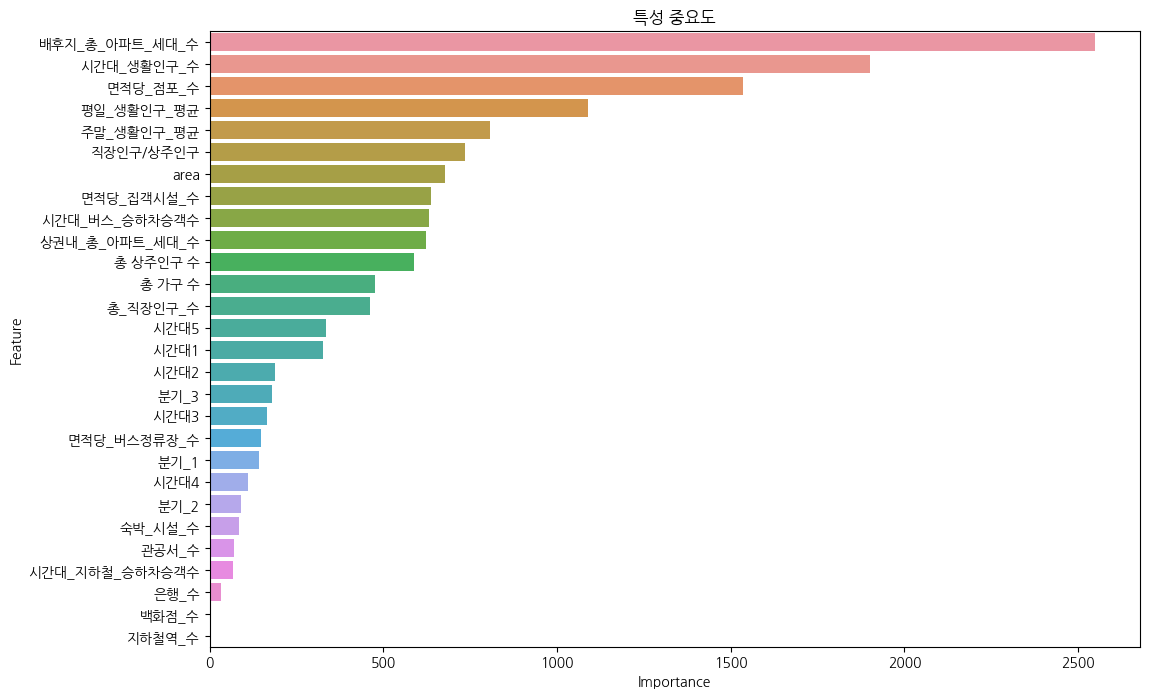

K-fold 교차 검증을 위한 최적 하이퍼파라미터:
Fold 1: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 2: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 3: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 4: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 5: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}


In [27]:
# 데이터 로드(실제 데이터셋 가져오기)
features = ['시간대1', '시간대2', '시간대3', '시간대4', '시간대5', '분기_1', '분기_2', '분기_3', 'area',
       '총 상주인구 수', '총 가구 수', '총_직장인구_수', '상권내_총_아파트_세대_수', '배후지_총_아파트_세대_수',
        '시간대_생활인구_수', '평일_생활인구_평균', '주말_생활인구_평균', '관공서_수', '은행_수', '면적당_점포_수',
       '백화점_수', '숙박_시설_수', '시간대_버스_승하차승객수', '시간대_지하철_승하차승객수', '면적당_버스정류장_수',
       '직장인구/상주인구', '면적당_집객시설_수', '지하철역_수']

X = data1[features]
y = data1['매출']

# 데이터를 훈련세트와 테스트 세트로 나눔(test_size 설정 필요, 임의로 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# k-폴드 교차 검증
num_folds = 5
kf = KFold(n_splits= num_folds, shuffle=True, random_state=42)


# LightGBM 모델 초기화
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# 특성 중요도 리스트 초기화
feature_importance_list = []

# 결과 스코어
rmse_scores = []  # RMSE 스코어를 저장할 리스트
mae_scores = []   # MAE 스코어를 저장할 리스트
best_params_list = []  # 각 fold에서의 최적 파라미터를 저장할 리스트

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 파라미터 범위 설정 (랜덤 서치용)
param_dist = {
    'objective': ['regression'],
    'metric': ['mse'],
    'num_leaves': list(range(7, 64)),              # 7부터 63까지
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],  #0.01부터 0.05까지
    'n_estimators': list(range(200, 301)),         # 200부터 300까지
    'early_stopping_rounds': list(range(40, 51))  # 40부터 50까지
}


# K-Fold 교차 검증 수행
for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X.iloc[train_index], X.iloc[val_index]
    y_train_kf, y_val_kf = y.iloc[train_index], y.iloc[val_index]


    # 데이터셋
    train_data = lgb.Dataset(X_train_kf, label=y_train_kf)
    val_data = lgb.Dataset(X_val_kf, label=y_val_kf, reference=train_data)


    # 랜덤 서치를 사용한 LightGBM 모델 튜닝
    random_search = RandomizedSearchCV(
        lgb.LGBMRegressor(),
        param_distributions=param_dist,
        n_iter=10,
        scoring='neg_mean_squared_error',
        cv=kf,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    evals = [(X_train_kf, y_train_kf),(X_val_kf, y_val_kf)]
    random_search.fit(X_train_kf, y_train_kf, eval_set = evals, eval_metric='rmse')
    best_params = random_search.best_params_

    bst = lgb.LGBMRegressor(**best_params)

    bst.fit(X_train_kf, y_train_kf,
            eval_set=evals,
            eval_metric='rmse',
            verbose=False)
    

    #Feature importance 계산
    feature_importance = bst.feature_importances_
    feature_importance_list.append(feature_importance)


    # 모델 평가 (RMSE)
    y_pred = bst.predict(X_val_kf)
    mse = mean_squared_error(y_val_kf, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred))
    mae = mean_absolute_error(y_val_kf, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    best_params_list.append(best_params)


# 교차 검증 결과 출력
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)
print(f'평균 RMSE: {mean_rmse}')
print(f'평균 MAE: {mean_mae}')

# 특성 중요도 평균 계산
average_feature_importance = np.mean(feature_importance_list, axis=0)

# 특성 이름
feature_names = X.columns


# 중요도를 특성 이름과 함께 출력
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': average_feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# 특성 중요도 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('특성 중요도')
plt.show()

# K-fold 교차 검증에서 얻은 최적 파라미터 출력
print("K-fold 교차 검증을 위한 최적 하이퍼파라미터:")
for i, params in enumerate(best_params_list):
    print(f'Fold {i + 1}: {params}')

### 3단계 시작

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=44, early_stopping_rounds=44 will be ignored. Current value: early_stopping_round=44
[1]	training's rmse: 152190	training's l2: 2.31618e+10	valid_1's rmse: 140222	valid_1's l2: 1.96622e+10
[2]	training's rmse: 148034	training's l2: 2.19139e+10	valid_1's rmse: 136504	valid_1's l2: 1.86335e+10
[3]	training's rmse: 144097	training's l2: 2.07638e+10	valid_1's rmse: 132944	valid_1's l2: 1.76741e+10
[4]	training's rmse: 140326	training's l2: 1.96913e+10	valid_1's rmse: 129544	valid_1's l2: 1.67817e+10
[5]	training's rmse: 136745	training's l2: 1.86991e+10	valid_1's rmse: 126292	valid_1's l2: 1.59496e+10
[6]	training's rmse: 133371	training's l2: 1.77878e+10	valid_1's rmse: 123160	valid_1's l2: 1.51684e+10
[7]	training's rmse: 130098	training's l2: 1.69254e+10	valid_1's rmse: 120406	valid_1's l2: 1.44977e+10
[8]	training's rmse: 126994	training's l2: 1.61275e+10	valid_1's rmse: 117808

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 141822	training's l2: 2.01136e+10	valid_1's rmse: 174812	valid_1's l2: 3.05592e+10
[2]	training's rmse: 136837	training's l2: 1.87244e+10	valid_1's rmse: 169241	valid_1's l2: 2.86425e+10
[3]	training's rmse: 132258	training's l2: 1.74921e+10	valid_1's rmse: 164668	valid_1's l2: 2.71155e+10
[4]	training's rmse: 127834	training's l2: 1.63416e+10	valid_1's rmse: 159766	valid_1's l2: 2.55252e+10
[5]	training's rmse: 123587	training's l2: 1.52738e+10	valid_1's rmse: 154980	valid_1's l2: 2.40187e+10
[6]	training's rmse: 119783	training's l2: 1.43481e+10	valid_1's rmse: 151108	valid_1's l2: 2.28337e+10
[7]	training's rmse: 116014	training's l2: 1.34593e+10	valid_1's rmse: 147470	valid_1's l2: 2.17473e+10
[8]	training's rmse: 112446	training's l2: 1.26441e+10	valid_1's rmse: 143850

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=44, early_stopping_rounds=44 will be ignored. Current value: early_stopping_round=44
[1]	training's rmse: 147065	training's l2: 2.16281e+10	valid_1's rmse: 161592	valid_1's l2: 2.61119e+10
[2]	training's rmse: 143194	training's l2: 2.05047e+10	valid_1's rmse: 157897	valid_1's l2: 2.49316e+10
[3]	training's rmse: 139388	training's l2: 1.94291e+10	valid_1's rmse: 154284	valid_1's l2: 2.38034e+10
[4]	training's rmse: 135476	training's l2: 1.83539e+10	valid_1's rmse: 150716	valid_1's l2: 2.27154e+10
[5]	training's rmse: 131763	training's l2: 1.73616e+10	valid_1's rmse: 147310	valid_1's l2: 2.17002e+10
[6]	training's rmse: 128219	training's l2: 1.644e+10	valid_1's rmse: 143985	valid_1's l2: 2.07317e+10
[7]	training's rmse: 124882	training's l2: 1.55956e+10	valid_1's rmse: 140803	valid_1's l2: 1.98255e+10
[8]	training's rmse: 121705	training's l2: 1.48122e+10	valid_1's rmse: 138024	v

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 152713	training's l2: 2.33213e+10	valid_1's rmse: 130413	valid_1's l2: 1.70075e+10
[2]	training's rmse: 147247	training's l2: 2.16816e+10	valid_1's rmse: 125441	valid_1's l2: 1.57354e+10
[3]	training's rmse: 142116	training's l2: 2.01969e+10	valid_1's rmse: 120831	valid_1's l2: 1.46002e+10
[4]	training's rmse: 137266	training's l2: 1.88418e+10	valid_1's rmse: 116515	valid_1's l2: 1.35758e+10
[5]	training's rmse: 132722	training's l2: 1.76152e+10	valid_1's rmse: 112453	valid_1's l2: 1.26456e+10
[6]	training's rmse: 128480	training's l2: 1.65071e+10	valid_1's rmse: 108770	valid_1's l2: 1.18309e+10
[7]	training's rmse: 124513	training's l2: 1.55035e+10	valid_1's rmse: 105347	valid_1's l2: 1.10979e+10
[8]	training's rmse: 120789	training's l2: 1.459e+10	valid_1's rmse: 102213	v

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 151376	training's l2: 2.29146e+10	valid_1's rmse: 136844	valid_1's l2: 1.87263e+10
[2]	training's rmse: 146073	training's l2: 2.13375e+10	valid_1's rmse: 132046	valid_1's l2: 1.74362e+10
[3]	training's rmse: 141108	training's l2: 1.99115e+10	valid_1's rmse: 127481	valid_1's l2: 1.62514e+10
[4]	training's rmse: 136383	training's l2: 1.86002e+10	valid_1's rmse: 122989	valid_1's l2: 1.51263e+10
[5]	training's rmse: 131947	training's l2: 1.741e+10	valid_1's rmse: 118766	valid_1's l2: 1.41053e+10
[6]	training's rmse: 127750	training's l2: 1.632e+10	valid_1's rmse: 114836	valid_1's l2: 1.31874e+10
[7]	training's rmse: 123597	training's l2: 1.52763e+10	valid_1's rmse: 111195	valid_1's l2: 1.23644e+10
[8]	training's rmse: 119823	training's l2: 1.43577e+10	valid_1's rmse: 107766	val

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


평균 RMSE: 45023.42767899702
평균 MAE: 26433.786449117215
           Feature  Importance
11  배후지_총_아파트_세대_수      2119.6
12      시간대_생활인구_수      1622.6
15        면적당_점포_수      1513.0
13      평일_생활인구_평균      1044.0
8           총 가구 수       864.6
14      주말_생활인구_평균       769.2
19       직장인구/상주인구       764.4
10  상권내_총_아파트_세대_수       641.4
20      면적당_집객시설_수       620.6
9         총_직장인구_수       553.8
4             시간대5       294.0
0             시간대1       292.0
18     면적당_버스정류장_수       221.0
1             시간대2       160.4
7             분기_3       142.8
2             시간대3       128.8
5             분기_1       120.6
17  시간대_지하철_승하차승객수       100.6
16         숙박_시설_수        91.4
3             시간대4        87.0
6             분기_2        75.4


C:\Users\user\Downloads\Project_1\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\Downloads\Project_1\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\Downloads\Project_1\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


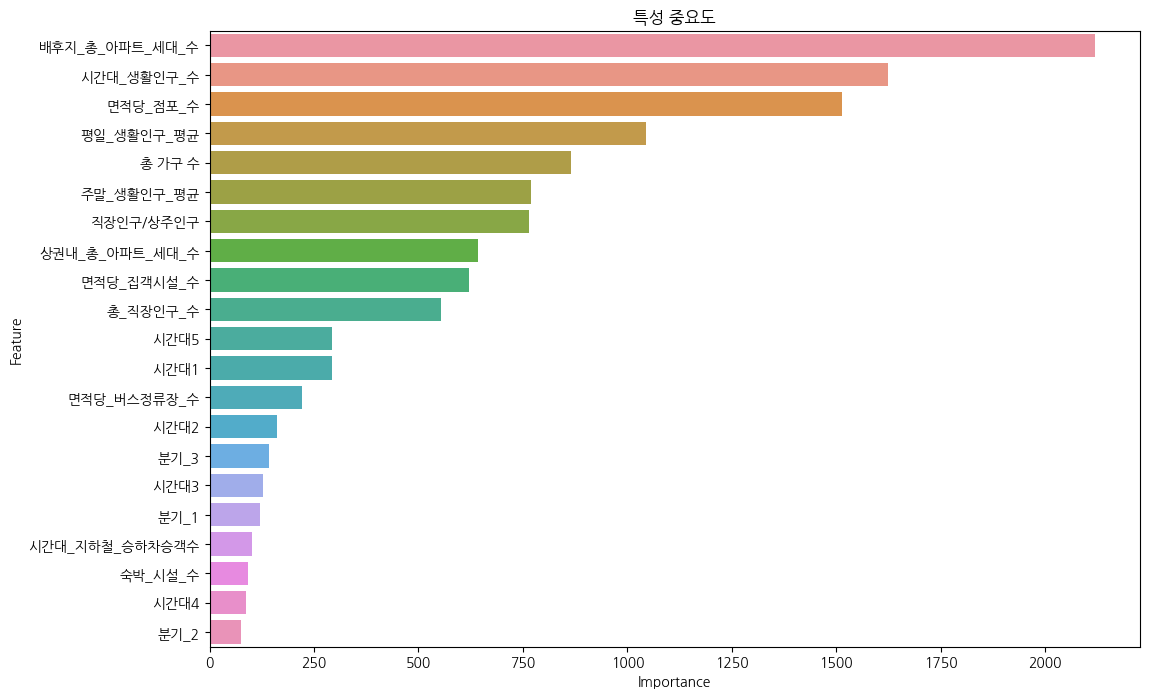

K-fold 교차 검증을 위한 최적 하이퍼파라미터:
Fold 1: {'objective': 'regression', 'num_leaves': 31, 'n_estimators': 286, 'metric': 'mse', 'learning_rate': 0.04, 'early_stopping_rounds': 44}
Fold 2: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 3: {'objective': 'regression', 'num_leaves': 31, 'n_estimators': 286, 'metric': 'mse', 'learning_rate': 0.04, 'early_stopping_rounds': 44}
Fold 4: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 5: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}


In [34]:
# 데이터 로드(실제 데이터셋 가져오기)
features = ['시간대1', '시간대2', '시간대3', '시간대4', '시간대5', '분기_1', '분기_2', '분기_3',
       '총 가구 수', '총_직장인구_수', '상권내_총_아파트_세대_수', '배후지_총_아파트_세대_수',
        '시간대_생활인구_수', '평일_생활인구_평균', '주말_생활인구_평균', '면적당_점포_수',
       '숙박_시설_수', '시간대_지하철_승하차승객수', '면적당_버스정류장_수',
       '직장인구/상주인구', '면적당_집객시설_수']

X = data1[features]
y = data1['매출']

# 데이터를 훈련세트와 테스트 세트로 나눔(test_size 설정 필요, 임의로 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# k-폴드 교차 검증
num_folds = 5
kf = KFold(n_splits= num_folds, shuffle=True, random_state=42)


# LightGBM 모델 초기화
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# 특성 중요도 리스트 초기화
feature_importance_list = []

# 결과 스코어
rmse_scores = []  # RMSE 스코어를 저장할 리스트
mae_scores = []   # MAE 스코어를 저장할 리스트
best_params_list = []  # 각 fold에서의 최적 파라미터를 저장할 리스트

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 파라미터 범위 설정 (랜덤 서치용)
param_dist = {
    'objective': ['regression'],
    'metric': ['mse'],
    'num_leaves': list(range(7, 64)),              # 7부터 63까지
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],  #0.01부터 0.05까지
    'n_estimators': list(range(200, 301)),         # 200부터 300까지
    'early_stopping_rounds': list(range(40, 51))  # 40부터 50까지
}


# K-Fold 교차 검증 수행
for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X.iloc[train_index], X.iloc[val_index]
    y_train_kf, y_val_kf = y.iloc[train_index], y.iloc[val_index]


    # 데이터셋
    train_data = lgb.Dataset(X_train_kf, label=y_train_kf)
    val_data = lgb.Dataset(X_val_kf, label=y_val_kf, reference=train_data)


    # 랜덤 서치를 사용한 LightGBM 모델 튜닝
    random_search = RandomizedSearchCV(
        lgb.LGBMRegressor(),
        param_distributions=param_dist,
        n_iter=10,
        scoring='neg_mean_squared_error',
        cv=kf,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    evals = [(X_train_kf, y_train_kf),(X_val_kf, y_val_kf)]
    random_search.fit(X_train_kf, y_train_kf, eval_set = evals, eval_metric='rmse')
    best_params = random_search.best_params_

    bst = lgb.LGBMRegressor(**best_params)

    bst.fit(X_train_kf, y_train_kf,
            eval_set=evals,
            eval_metric='rmse',
            verbose=False)
    

    #Feature importance 계산
    feature_importance = bst.feature_importances_
    feature_importance_list.append(feature_importance)


    # 모델 평가 (RMSE)
    y_pred = bst.predict(X_val_kf)
    mse = mean_squared_error(y_val_kf, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred))
    mae = mean_absolute_error(y_val_kf, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    best_params_list.append(best_params)


# 교차 검증 결과 출력
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)
print(f'평균 RMSE: {mean_rmse}')
print(f'평균 MAE: {mean_mae}')

# 특성 중요도 평균 계산
average_feature_importance = np.mean(feature_importance_list, axis=0)

# 특성 이름
feature_names = X.columns


# 중요도를 특성 이름과 함께 출력
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': average_feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# 특성 중요도 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('특성 중요도')
plt.show()

# K-fold 교차 검증에서 얻은 최적 파라미터 출력
print("K-fold 교차 검증을 위한 최적 하이퍼파라미터:")
for i, params in enumerate(best_params_list):
    print(f'Fold {i + 1}: {params}')

#  ㅡㅡㅡ

## 시뮬용 머신러닝

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 151100	training's l2: 2.28312e+10	valid_1's rmse: 120791	valid_1's l2: 1.45904e+10
[2]	training's rmse: 145579	training's l2: 2.11932e+10	valid_1's rmse: 116296	valid_1's l2: 1.35248e+10
[3]	training's rmse: 140407	training's l2: 1.97142e+10	valid_1's rmse: 112092	valid_1's l2: 1.25646e+10
[4]	training's rmse: 135446	training's l2: 1.83457e+10	valid_1's rmse: 108303	valid_1's l2: 1.17295e+10
[5]	training's rmse: 130838	training's l2: 1.71187e+10	valid_1's rmse: 104314	valid_1's l2: 1.08814e+10
[6]	training's rmse: 126436	training's l2: 1.59861e+10	valid_1's rmse: 100511	valid_1's l2: 1.01024e+10
[7]	training's rmse: 122320	training's l2: 1.49621e+10	valid_1's rmse: 96972.5	valid_1's l2: 9.40368e+09
[8]	training's rmse: 118435	training's l2: 1.40268e+10	valid_1's rmse: 934

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 147786	training's l2: 2.18407e+10	valid_1's rmse: 154493	valid_1's l2: 2.3868e+10
[2]	training's rmse: 142433	training's l2: 2.02873e+10	valid_1's rmse: 148935	valid_1's l2: 2.21817e+10
[3]	training's rmse: 137360	training's l2: 1.88678e+10	valid_1's rmse: 144052	valid_1's l2: 2.0751e+10
[4]	training's rmse: 132642	training's l2: 1.75938e+10	valid_1's rmse: 139489	valid_1's l2: 1.94572e+10
[5]	training's rmse: 128209	training's l2: 1.64374e+10	valid_1's rmse: 134882	valid_1's l2: 1.81931e+10
[6]	training's rmse: 124013	training's l2: 1.53792e+10	valid_1's rmse: 130856	valid_1's l2: 1.71234e+10
[7]	training's rmse: 120076	training's l2: 1.44182e+10	valid_1's rmse: 127053	valid_1's l2: 1.61424e+10
[8]	training's rmse: 116453	training's l2: 1.35613e+10	valid_1's rmse: 123570

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 144081	training's l2: 2.07592e+10	valid_1's rmse: 184427	valid_1's l2: 3.40135e+10
[2]	training's rmse: 138843	training's l2: 1.92772e+10	valid_1's rmse: 179033	valid_1's l2: 3.20529e+10
[3]	training's rmse: 133956	training's l2: 1.79441e+10	valid_1's rmse: 173957	valid_1's l2: 3.0261e+10
[4]	training's rmse: 129370	training's l2: 1.67365e+10	valid_1's rmse: 169147	valid_1's l2: 2.86107e+10
[5]	training's rmse: 125067	training's l2: 1.56418e+10	valid_1's rmse: 164647	valid_1's l2: 2.71085e+10
[6]	training's rmse: 121057	training's l2: 1.46549e+10	valid_1's rmse: 160364	valid_1's l2: 2.57166e+10
[7]	training's rmse: 117325	training's l2: 1.37651e+10	valid_1's rmse: 156417	valid_1's l2: 2.44663e+10
[8]	training's rmse: 113588	training's l2: 1.29022e+10	valid_1's rmse: 15232

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 146846	training's l2: 2.15637e+10	valid_1's rmse: 162171	valid_1's l2: 2.62994e+10
[2]	training's rmse: 141592	training's l2: 2.00484e+10	valid_1's rmse: 156174	valid_1's l2: 2.43904e+10
[3]	training's rmse: 136648	training's l2: 1.86728e+10	valid_1's rmse: 150643	valid_1's l2: 2.26933e+10
[4]	training's rmse: 132016	training's l2: 1.74281e+10	valid_1's rmse: 145328	valid_1's l2: 2.11202e+10
[5]	training's rmse: 127382	training's l2: 1.62263e+10	valid_1's rmse: 140752	valid_1's l2: 1.98113e+10
[6]	training's rmse: 123260	training's l2: 1.5193e+10	valid_1's rmse: 135874	valid_1's l2: 1.84617e+10
[7]	training's rmse: 119307	training's l2: 1.42341e+10	valid_1's rmse: 131230	valid_1's l2: 1.72214e+10
[8]	training's rmse: 115325	training's l2: 1.32997e+10	valid_1's rmse: 12717

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 147433	training's l2: 2.17366e+10	valid_1's rmse: 156979	valid_1's l2: 2.46424e+10
[2]	training's rmse: 141985	training's l2: 2.01596e+10	valid_1's rmse: 152397	valid_1's l2: 2.32249e+10
[3]	training's rmse: 136800	training's l2: 1.87141e+10	valid_1's rmse: 148112	valid_1's l2: 2.19372e+10
[4]	training's rmse: 131999	training's l2: 1.74238e+10	valid_1's rmse: 144173	valid_1's l2: 2.07859e+10
[5]	training's rmse: 127495	training's l2: 1.6255e+10	valid_1's rmse: 140532	valid_1's l2: 1.97492e+10
[6]	training's rmse: 123194	training's l2: 1.51767e+10	valid_1's rmse: 136351	valid_1's l2: 1.85916e+10
[7]	training's rmse: 119117	training's l2: 1.41888e+10	valid_1's rmse: 132389	valid_1's l2: 1.75267e+10
[8]	training's rmse: 115407	training's l2: 1.33188e+10	valid_1's rmse: 12928

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 146928	training's l2: 2.15878e+10	valid_1's rmse: 163117	valid_1's l2: 2.66073e+10
[2]	training's rmse: 141783	training's l2: 2.01023e+10	valid_1's rmse: 157711	valid_1's l2: 2.48729e+10
[3]	training's rmse: 136611	training's l2: 1.86625e+10	valid_1's rmse: 152680	valid_1's l2: 2.33111e+10
[4]	training's rmse: 131760	training's l2: 1.73608e+10	valid_1's rmse: 147879	valid_1's l2: 2.18681e+10
[5]	training's rmse: 127195	training's l2: 1.61787e+10	valid_1's rmse: 143474	valid_1's l2: 2.05849e+10
[6]	training's rmse: 122950	training's l2: 1.51166e+10	valid_1's rmse: 139364	valid_1's l2: 1.94222e+10
[7]	training's rmse: 118886	training's l2: 1.4134e+10	valid_1's rmse: 135514	valid_1's l2: 1.83641e+10
[8]	training's rmse: 115028	training's l2: 1.32315e+10	valid_1's rmse: 13173

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 151589	training's l2: 2.29793e+10	valid_1's rmse: 117241	valid_1's l2: 1.37455e+10
[2]	training's rmse: 146031	training's l2: 2.13249e+10	valid_1's rmse: 112461	valid_1's l2: 1.26474e+10
[3]	training's rmse: 141017	training's l2: 1.98859e+10	valid_1's rmse: 107971	valid_1's l2: 1.16577e+10
[4]	training's rmse: 136037	training's l2: 1.8506e+10	valid_1's rmse: 103715	valid_1's l2: 1.07568e+10
[5]	training's rmse: 131553	training's l2: 1.73062e+10	valid_1's rmse: 99741.8	valid_1's l2: 9.94842e+09
[6]	training's rmse: 127047	training's l2: 1.61408e+10	valid_1's rmse: 95983.8	valid_1's l2: 9.21289e+09
[7]	training's rmse: 122893	training's l2: 1.51026e+10	valid_1's rmse: 92526.5	valid_1's l2: 8.56115e+09
[8]	training's rmse: 119100	training's l2: 1.41849e+10	valid_1's rmse: 89

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 149024	training's l2: 2.22083e+10	valid_1's rmse: 142435	valid_1's l2: 2.02878e+10
[2]	training's rmse: 143543	training's l2: 2.06046e+10	valid_1's rmse: 137863	valid_1's l2: 1.90063e+10
[3]	training's rmse: 138376	training's l2: 1.91478e+10	valid_1's rmse: 133297	valid_1's l2: 1.7768e+10
[4]	training's rmse: 133537	training's l2: 1.78323e+10	valid_1's rmse: 129113	valid_1's l2: 1.66702e+10
[5]	training's rmse: 128990	training's l2: 1.66385e+10	valid_1's rmse: 125075	valid_1's l2: 1.56438e+10
[6]	training's rmse: 124685	training's l2: 1.55464e+10	valid_1's rmse: 121272	valid_1's l2: 1.47069e+10
[7]	training's rmse: 120441	training's l2: 1.45061e+10	valid_1's rmse: 117651	valid_1's l2: 1.38416e+10
[8]	training's rmse: 116482	training's l2: 1.35681e+10	valid_1's rmse: 11417

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 149286	training's l2: 2.22862e+10	valid_1's rmse: 140481	valid_1's l2: 1.97348e+10
[2]	training's rmse: 143874	training's l2: 2.06996e+10	valid_1's rmse: 135727	valid_1's l2: 1.84219e+10
[3]	training's rmse: 138881	training's l2: 1.92878e+10	valid_1's rmse: 131026	valid_1's l2: 1.71679e+10
[4]	training's rmse: 134141	training's l2: 1.79938e+10	valid_1's rmse: 127072	valid_1's l2: 1.61473e+10
[5]	training's rmse: 129649	training's l2: 1.68088e+10	valid_1's rmse: 122651	valid_1's l2: 1.50433e+10
[6]	training's rmse: 125324	training's l2: 1.5706e+10	valid_1's rmse: 119242	valid_1's l2: 1.42187e+10
[7]	training's rmse: 121250	training's l2: 1.47016e+10	valid_1's rmse: 115855	valid_1's l2: 1.34224e+10
[8]	training's rmse: 117449	training's l2: 1.37944e+10	valid_1's rmse: 11286

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fitting 10 folds for each of 10 candidates, totalling 100 fits
[LightGBM] [Warning] early_stopping_round is set=41, early_stopping_rounds=41 will be ignored. Current value: early_stopping_round=41
[1]	training's rmse: 149988	training's l2: 2.24965e+10	valid_1's rmse: 132839	valid_1's l2: 1.76461e+10
[2]	training's rmse: 144669	training's l2: 2.09292e+10	valid_1's rmse: 127676	valid_1's l2: 1.63012e+10
[3]	training's rmse: 139536	training's l2: 1.94703e+10	valid_1's rmse: 122620	valid_1's l2: 1.50356e+10
[4]	training's rmse: 134750	training's l2: 1.81576e+10	valid_1's rmse: 117982	valid_1's l2: 1.39198e+10
[5]	training's rmse: 130191	training's l2: 1.69497e+10	valid_1's rmse: 113573	valid_1's l2: 1.28987e+10
[6]	training's rmse: 125974	training's l2: 1.58695e+10	valid_1's rmse: 109562	valid_1's l2: 1.20038e+10
[7]	training's rmse: 121887	training's l2: 1.48565e+10	valid_1's rmse: 105691	valid_1's l2: 1.11705e+10
[8]	training's rmse: 118205	training's l2: 1.39724e+10	valid_1's rmse: 1023

C:\Users\user\Downloads\Project_1\venv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


평균 RMSE: 43434.26953654214
평균 MAE: 24839.732288540257
           Feature  Importance
11  배후지_총_아파트_세대_수      2561.1
12      시간대_생활인구_수      2134.6
15        면적당_점포_수      1750.6
13      평일_생활인구_평균      1336.0
8           총 가구 수      1048.8
14      주말_생활인구_평균       981.5
16       직장인구/상주인구       955.5
10  상권내_총_아파트_세대_수       857.5
17      면적당_집객시설_수       784.4
9         총_직장인구_수       688.3
0             시간대1       357.7
4             시간대5       338.8
1             시간대2       200.6
7             분기_3       168.6
2             시간대3       158.9
5             분기_1       149.5
3             시간대4       113.4
6             분기_2        88.2


C:\Users\user\Downloads\Project_1\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\Downloads\Project_1\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\user\Downloads\Project_1\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


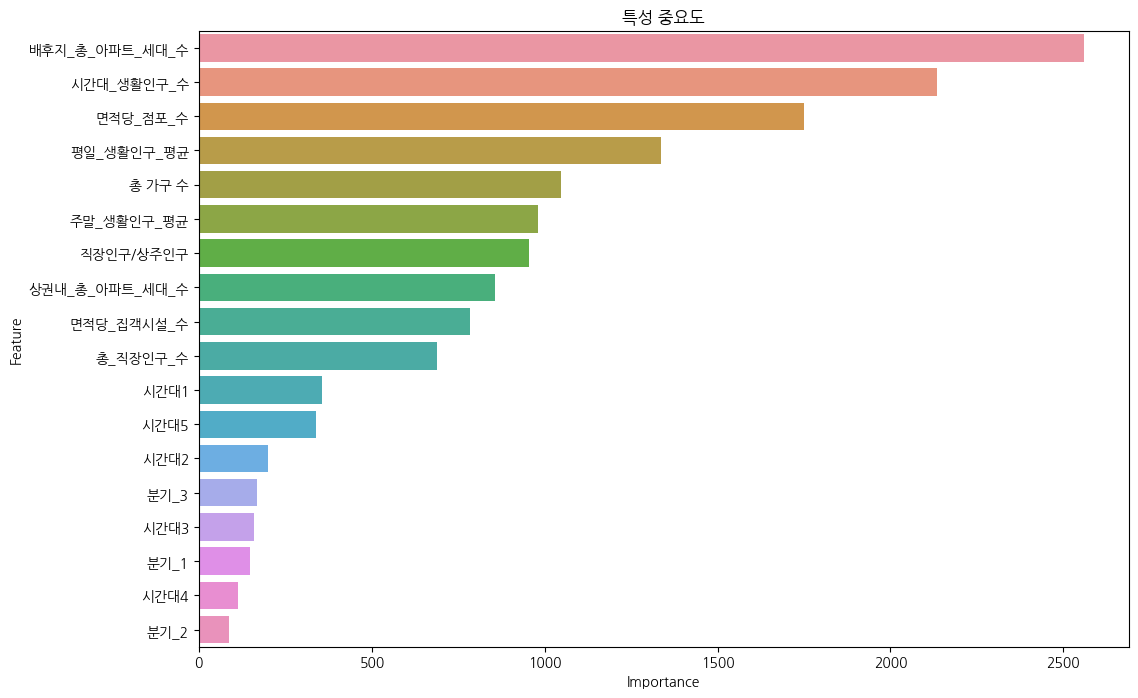

K-fold 교차 검증을 위한 최적 하이퍼파라미터:
Fold 1: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 2: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 3: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 4: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 5: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 6: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate': 0.05, 'early_stopping_rounds': 41}
Fold 7: {'objective': 'regression', 'num_leaves': 59, 'n_estimators': 253, 'metric': 'mse', 'learning_rate'

In [51]:
# 데이터 로드(실제 데이터셋 가져오기)
features = ['시간대1', '시간대2', '시간대3', '시간대4', '시간대5', '분기_1', '분기_2', '분기_3',
       '총 가구 수', '총_직장인구_수', '상권내_총_아파트_세대_수', '배후지_총_아파트_세대_수',
        '시간대_생활인구_수', '평일_생활인구_평균', '주말_생활인구_평균', '면적당_점포_수',
       '직장인구/상주인구', '면적당_집객시설_수']

X = data1[features]
y = data1['매출']

# 데이터를 훈련세트와 테스트 세트로 나눔(test_size 설정 필요, 임의로 0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# k-폴드 교차 검증
num_folds = 10
kf = KFold(n_splits= num_folds, shuffle=True, random_state=42)


# LightGBM 모델 초기화
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# 특성 중요도 리스트 초기화
feature_importance_list = []

# 결과 스코어
rmse_scores = []  # RMSE 스코어를 저장할 리스트
mae_scores = []   # MAE 스코어를 저장할 리스트
best_params_list = []  # 각 fold에서의 최적 파라미터를 저장할 리스트

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 파라미터 범위 설정 (랜덤 서치용)
param_dist = {
    'objective': ['regression'],
    'metric': ['mse'],
    'num_leaves': list(range(7, 64)),              # 7부터 63까지
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],  #0.01부터 0.05까지
    'n_estimators': list(range(200, 301)),         # 200부터 300까지
    'early_stopping_rounds': list(range(40, 51))  # 40부터 50까지
}


# K-Fold 교차 검증 수행
for train_index, val_index in kf.split(X_train):
    X_train_kf, X_val_kf = X.iloc[train_index], X.iloc[val_index]
    y_train_kf, y_val_kf = y.iloc[train_index], y.iloc[val_index]


    # 데이터셋
    train_data = lgb.Dataset(X_train_kf, label=y_train_kf)
    val_data = lgb.Dataset(X_val_kf, label=y_val_kf, reference=train_data)


    # 랜덤 서치를 사용한 LightGBM 모델 튜닝
    random_search = RandomizedSearchCV(
        lgb.LGBMRegressor(),
        param_distributions=param_dist,
        n_iter=10,
        scoring='neg_mean_squared_error',
        cv=kf,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )

    evals = [(X_train_kf, y_train_kf),(X_val_kf, y_val_kf)]
    random_search.fit(X_train_kf, y_train_kf, eval_set = evals, eval_metric='rmse')
    best_params = random_search.best_params_

    bst = lgb.LGBMRegressor(**best_params)

    bst.fit(X_train_kf, y_train_kf,
            eval_set=evals,
            eval_metric='rmse',
            verbose=False)
    

    #Feature importance 계산
    feature_importance = bst.feature_importances_
    feature_importance_list.append(feature_importance)


    # 모델 평가 (RMSE)
    y_pred = bst.predict(X_val_kf)
    mse = mean_squared_error(y_val_kf, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_kf, y_pred))
    mae = mean_absolute_error(y_val_kf, y_pred)

    rmse_scores.append(rmse)
    mae_scores.append(mae)
    best_params_list.append(best_params)


# 교차 검증 결과 출력
mean_rmse = np.mean(rmse_scores)
mean_mae = np.mean(mae_scores)
print(f'평균 RMSE: {mean_rmse}')
print(f'평균 MAE: {mean_mae}')

# 특성 중요도 평균 계산
average_feature_importance = np.mean(feature_importance_list, axis=0)

# 특성 이름
feature_names = X.columns


# 중요도를 특성 이름과 함께 출력
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': average_feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# 특성 중요도 시각화
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('특성 중요도')
plt.show()

# K-fold 교차 검증에서 얻은 최적 파라미터 출력
print("K-fold 교차 검증을 위한 최적 하이퍼파라미터:")
for i, params in enumerate(best_params_list):
    print(f'Fold {i + 1}: {params}')